<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #5


## Tutorial 2.3: PyCBC Tutorial, Signal Consistency and Significance

We will be using the [PyCBC](http://github.com/gwastro/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through finding a peak in a noisy signal and estimating its significance given a simplified search. Some assumptions will be noted along the way. We will also make use of one of the standard signal consistency tests to help remove some non-Gaussian transient noise from the background.

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2022/blob/main/Tutorials/Day_2/Tuto_2.3_Signal_consistency_and_significance.ipynb)

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

## Installation (execute only if running on a cloud platform!)

In [1]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==7.3' 'PyCBC==2.0.1'

     |████████████████████████████████| 46.2 MB 96 kB/s 
     |████████████████████████████████| 6.7 MB 35.1 MB/s 
     |████████████████████████████████| 1.4 MB 41.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 6.0 MB/s 
     |████████████████████████████████| 7.3 MB 49.1 MB/s 
     |████████████████████████████████| 78 kB 4.9 MB/s 
     |████████████████████████████████| 45 kB 2.2 MB/s 
     |████████████████████████████████| 201 kB 56.3 MB/s 
     |████████████████████████████████| 318 kB 54.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 295 kB 62.7 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 1.3 MB 49.4 MB/s 
  Installing build dependencies ... done
  Getting requiremen

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Significance of Virgo SNR peak of GW170814 ###

We will estimate the significance of signal-to-noise peak observed in the Virgo instrument near in time to the large peaks observed in the LIGO-Hanford and LIGO-Livingston observatories.

For this purpose we will consider a gravitational wave signal, whose existence has been confirmed based on the signals from LIGO detectors alone. This was in fact the case for the matched-filtering based analyses of GW170814, as they did not incorporate any information from the Virgo data.

We ask ourselves the following question: *What is the probability that noise can produce a peak as large or larger than the largest peak observed in the Virgo data, and consistent with the lightspeed travel time between all three observatories?*

This is a form of null hypothesis testing, where we compute a [p-value](https://en.wikipedia.org/wiki/P-value) to answer the question above.

<!-- For the purpose of this notebook, we have added a few additional simplifying assumptions, and those will be stated as we go along. -->

#### Read and Precondition Gravitational Strain Data ####

In this section, we will read in a short segment of data around GW170814, and do some basic preconditioning, as also demonstrated in previous tutorials. We will also calculate the power spectrum of the data. 

Notably, here we assume that the power spectrum estimated from the data is constant over the short stretch of time, and isn't biased by our choice to center the estimate (very roughly) on the event time. We *do not* assume the data to be stationary, Gaussian, or free from non-astrophysical transient artefacts.

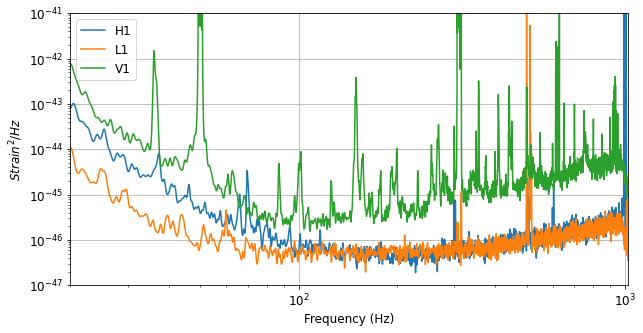

In [2]:
import pylab

from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
%matplotlib inline

m = Merger("GW170814")

ifos = ['H1', 'L1', 'V1']
data = {}
psd = {}

pylab.figure(figsize=[10, 5])

for ifo in ifos:
    # Read in and precondition the data
    ts = m.strain(ifo).highpass_fir(15, 512)
    data[ifo] = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

    # Estimate the power spectral density of the data
    # This chooses to use 2s samples in the PSD estimate.
    # One should note that the tradeoff in segment length is that
    # resolving narrow lines becomes more difficult.
    p = data[ifo].psd(2)
    p = interpolate(p, data[ifo].delta_f)
    p = inverse_spectrum_truncation(p, int(2 * data[ifo].sample_rate), low_frequency_cutoff=15.0)
    psd[ifo] = p
    
    pylab.plot(psd[ifo].sample_frequencies, psd[ifo], label=ifo)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-41)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

#### Generate our template waveform and calculate the Signal-to-noise time series ####

To calculate the signal-to-noise time series, we need to generate an estimate of the signal. For this purpose we will assume the source black holes are non spinning, have equal mass, and they agree with the total mass estimate for the system as a whole. A better method would be to use the maximum likelihood estimate from an analysis of the LIGO data alone, however, this is sufficient for the purposes of this tutorial.

In [3]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

# Calculate the component mass of each black hole in the detector frame
cmass = (m.median1d("mass1")+m.median1d("mass2")) / 2      # This is in the source frame
cmass *= (1 + m.median1d("redshift")) # apply redshift to get to the detector frame

# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used in prior tutorials. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, _ = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=cmass, mass2=cmass,
                         f_lower=20.0, delta_f=data[ifo].delta_f)
hp.resize(len(psd[ifo]))

# For each observatory use this template to calculate the SNR time series
snr = {}
for ifo in ifos:
    snr[ifo] = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=20)
    snr[ifo] = snr[ifo].crop(5, 4)

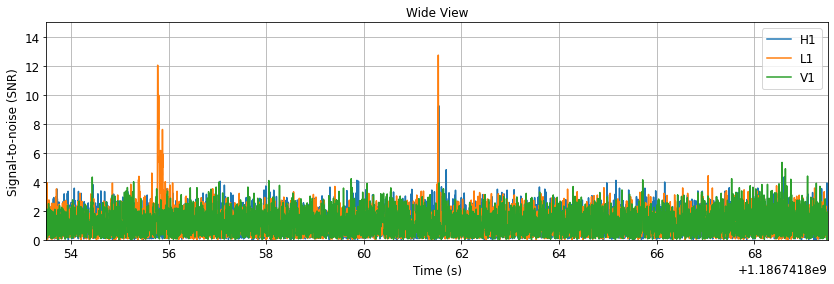

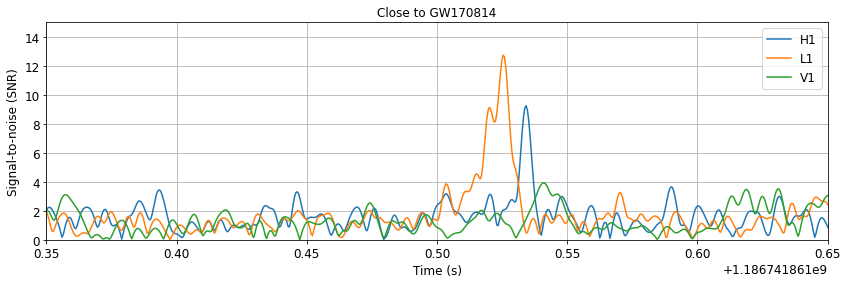

In [4]:
# Show a couple sizes
for w, title in [(8, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

We see in the SNR time series plots above, that while there are nice peaks around GW170814 in each detector, there are also some large peaks at other times. LIGO / Virgo data, does contain transient (i.e limited duration) noise artefacts that an analyses must deal with to search LIGO data with high sensitivity. One approach for dealing with this is outlined later in this tutorial.

#### How well is the data actually fitting our model? ####

One of the ways we can test how well the data actual fits the models to use a $\chi^2$-based signal consistency test. We employ a version of the test described [in this paper](https://arxiv.org/pdf/gr-qc/0405045.pdf). Schematically, we chop up our template into $p$ number of bins and see how much each contributes to the SNR ($\rho_i$). We can then calculate our statistic as the difference between the SNR in one bin, and the expected fraction of the total SNR ($\rho$).

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

This will have $2p-2$ degrees of freedom as each SNR is *complex* representing both possible orthogonal phases the signal could have contributions from. There is also a constraint due to the fact that the sum of each bin must each add up to the total SNR by definition. In this notebook we will normalize this statistic by dividing by the number of degrees of freedom, producing $\chi^2_r$.

We expect that this statistic will be high when the template does not match well with the data, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.

In [5]:
# WARNING!! If you are having problems with this code, replace the import with
#from pycbc_chisq import power_chisq
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    # The number of bins to use. In principle, this choice is arbitrary. In practice,
    # this is empirically tuned.
    nbins = 26
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, psd[ifo], low_frequency_cutoff=20.0)
    chisq[ifo] = chisq[ifo].crop(5, 4)
    
    dof = nbins * 2 - 2
    chisq[ifo] /= dof

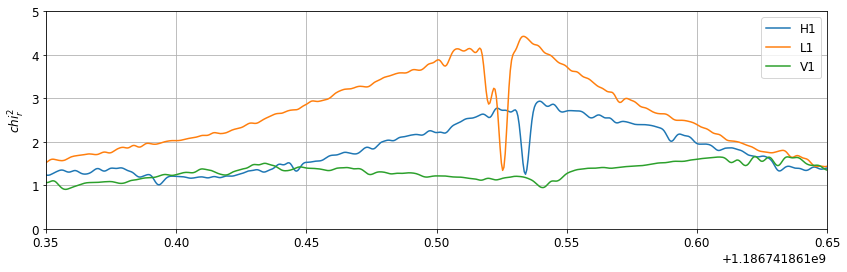

In [6]:
pylab.figure(figsize=[14, 4])

for ifo in ifos:
    pylab.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)
    
pylab.legend()
pylab.grid()
pylab.xlim(m.time -0.15, m.time + 0.15)
pylab.ylim(0, 5)
pylab.ylabel('$chi^2_r$')
pylab.show()

There are some notable features in the $\chi^2_r$ time series. We see that there is a dip in the value at the time of the peak in the SNR in each observatory. We expect this as the template now aligns with the signal in the data. Also, the values climb just around this minima. This occurs because the template is starting to slide against the true signal in the data but is not perfectly aligned with it.

#### Re-weighting our SNR to help down-weight times that don't fit our signal ####

One approach we can take is to down-weight the times where the data does not appear as either Guassian noise or Gaussian noise + our template. We can do this be combining the SNR time series and our $\chi^2_r$ time series as follows. This is a method used to re-weight SNR since initial LIGO, and has been employed in the first two Advanced LIGO observing runs. In this tutorial we will choose to rank our events by this statistic. 

$\hat{\rho} = \frac{\rho}{ [1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 > 1$, otherwise $\rho$

For reference on how we rank coincident (i.e. occuring in multiple detector) events in Advanced LIGO, there is a description [here](http://iopscience.iop.org/article/10.3847/1538-4357/aa8f50/pdf).

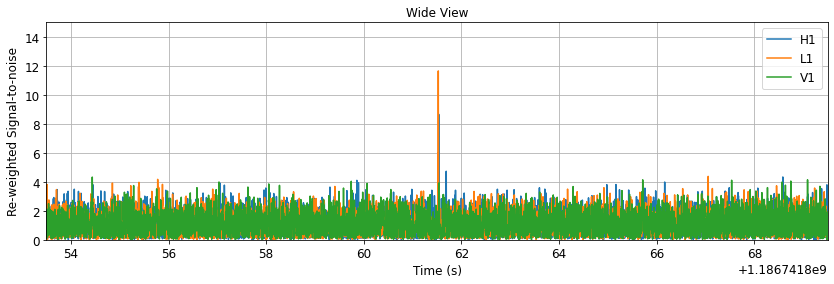

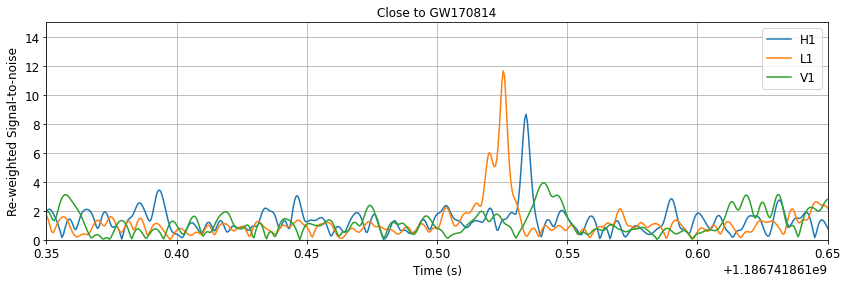

In [7]:
from pycbc.events.ranking import newsnr

# The rho-hat term above is named "newsnr" here
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}

# Show a couple sizes
for w, title in [(8, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()

We can see above that there are still peaks around GW170814 in all detectors, at roughly the same signal strength, but that at other times, where that had been peaks in the time series, there are no longer large statistic values.

#### Calculating the background and significance ####

In this section we will determine how significant the peak in the virgo re-weighted SNR time series is. 

We will do this first by determining where one might expect a peak relative to the LIGO observed peaks. This is set by the constraint that an astrophysical source can only cause delays between observatories no larger than the light travel time between them. The [`pycbc.detector.Detector`](http://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.detector.Detector) class provides some convenient methods to ask these sorts of questions.

We will then calculate the peak in the SNR for this window around the LIGO observed peaks. This is our "on-source". 

Finally, to determine the significance of the on-source we will compare how likely it is for a peak as large or larger to appear in the background. Our background will be empirically measured by taking portions of the SNR time series from the "off-source" i.e. times that do not overlap the on-source. An important criteria to avoid a biased significance estimate is that the background and experiment be performed in the same manner.

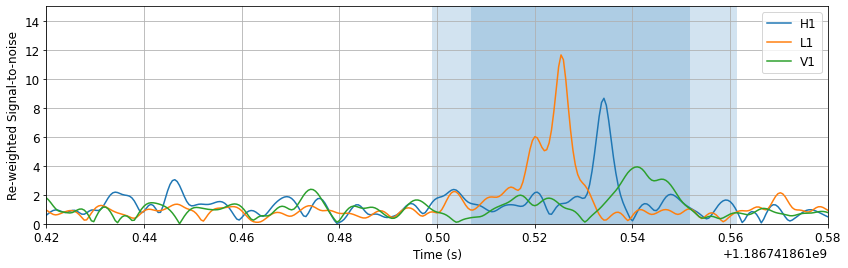

Virgo Peak has a statistic value of 3.928067368090521


In [8]:
import numpy
from pycbc.detector import Detector

# Calculate the time of flight between the Virgo detectors and each LIGO observatory
d = Detector("V1")
tof = {}
tof['H1'] = d.light_travel_time_to_detector(Detector("H1"))
tof['L1'] = d.light_travel_time_to_detector(Detector("L1"))

# Record the time of the peak in the LIGO observatories
ptime = {}

pylab.figure(figsize=[14, 4])
for ifo in ifos:
    
    # shade the region around each LIGO peak that could have a peak in Virgo if from
    # an astrophysical source
    if ifo != 'V1':
        ptime[ifo] = snr[ifo].sample_times[nsnr[ifo].argmax()]
        pylab.axvspan(ptime[ifo] - tof[ifo], ptime[ifo] + tof[ifo], alpha=0.2, lw=10)
        
    pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

# Calculate the span of time that a Virgo peak could in principle happen in from time of flight
# considerations.
start = ptime['H1'] - tof['H1']
end = ptime['L1'] + tof['L1']

# convert the times to indices along with how large the region is in number of samples
window_size = int((end - start) * snr['V1'].sample_rate)
sidx = int((start - snr['V1'].start_time) * snr['V1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak re-weighted (newsnr) statistic value.
onsource = nsnr['V1'][sidx:eidx].max()

pylab.legend()
pylab.grid()
pylab.xlim(m.time - .08, m.time + .08)
pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

print('Virgo Peak has a statistic value of {}'.format(onsource))

In the plot above we see the re-weighted SNR time series. On top of that we've shaded the regions which are consistent with a Virgo signal based on the peaks in the LIGO observatories. Only in the darker region, is it possible to have a peak in the SNR that is consistent with both LIGO observatories.

In [9]:
# Now that we've calculated the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = []
i = 0
while i + window_size < len(nsnr['V1']):
    p = nsnr['V1'][i:i+window_size].max()       # Here, we divide the window into the certain size and analyse each window.
    peaks.append(p)
    i += window_size
    
    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = numpy.array(peaks)

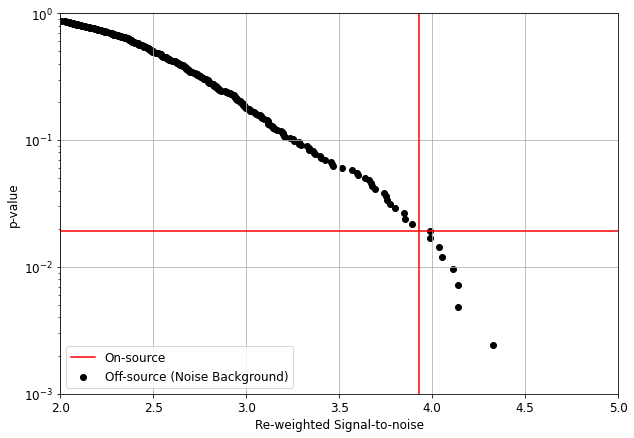

The p-value associated with the GW170814 peak is 0.01927710843373494


In [10]:
# The p-value is just the number of samples observed in the background with a 
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = numpy.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))

pylab.figure(figsize=[10, 7])
pylab.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

pylab.axvline(onsource, label='On-source', color='red')
pylab.axhline(pvalue, color='red')

pylab.legend()
pylab.yscale('log')
pylab.grid()
pylab.ylim(1e-3, 1e0)
pylab.ylabel('p-value')
pylab.xlabel('Re-weighted Signal-to-noise')

pylab.xlim(2, 5)
pylab.show()

print("The p-value associated with the GW170814 peak is {}".format(pvalue))

In this tutorial, we find a peak in Virgo as large as the obseved one has an approximately 2% chance of occuring due to the noise alone. Since that is a relatively low probability, we may reject the null hypothesis that the observed peak is due to noise alone. Given the simplifications of this tutorial, we find a result in agreement with the [GW170814 discovery paper](https://arxiv.org/pdf/1709.09660.pdf) which reported a p-value of 0.3%.

If the signal was much louder in the Virgo data, the Virgo peak would be larger than any peak in the noise background. In this case, this method of estimating the significance would only be able to set an upper bound on the p-value of the observed peak. In order to calculate the p-value of a much larger peak, we would either need to use more background data or make additional assumptions about the background distribution. If a gravitational-wave signal is extremely loud, it is challenging to calculate the precise significance of the observed peak, but we can still be confident that the signal is very significant! 

## Challenge!

Use the methods demonstrated above to see if you can calculate the SNR time series and re-weighted SNR timeseries in the following data set. This data set contains one signal and two glitches. At what times do you find peaks in the SNR timeseries? Which peaks are still present in the re-weighted SNR timeseries?

Information that may be useful:

* The signal and glitches are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass2 (equal mass) and that the component mass of the signal is 32.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [ ]:
# Download the challenge set files
from pycbc.frame import read_frame
import urllib.request

def get_file(fname):
    url = "https://github.com/gw-odw/odw-2022/raw/main/Tutorials/Day_2/Data/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T3_0.gwf']

for fname in files:
    get_file(fname)
    

# An example of how to read the data from these files:
file_name = "PyCBC_T3_0.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:TEST-STRAIN"

start = 0
end = start + 128

ts = read_frame(file_name, channel_name, start, end)